# Лабораторная работа 4 : Задача восстановления зависимостей. Линейная регрессия. Бустинг.

In [28]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


## Задание 1

In [29]:
# V = 83 => вариант 3

df = pd.read_csv("avocado.csv", parse_dates=True)
df = df.sample(frac=1)
df = df.reset_index()
df = df.rename(columns={"4046": "Small Hass",
               "4225": "Large Hass", "4770": "XLarge Hass"})
df = df.drop(columns=["Unnamed: 0", "index"])

stringValues = ['Date', 'type', 'region']
df[stringValues] = df[stringValues].apply(lambda x: pd.factorize(x)[0])

df


,Date,AveragePrice,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,1.48,749510.72,76382.33,472453.49,10119.64,190555.26,188395.17,2152.31,7.78,0,2017,0
1,1,0.90,1015264.05,590138.40,218435.64,3815.84,202874.17,123193.69,79430.48,250.00,0,2016,1
2,2,1.69,28577.15,4477.93,13302.64,40.44,10756.14,5955.98,4800.16,0.00,1,2015,2
3,3,1.83,6966.00,93.75,191.64,11.15,6669.46,5468.47,1200.99,0.00,1,2016,3
4,4,0.66,1203149.94,836443.14,223690.17,8294.96,134721.67,95992.23,38729.44,0.00,0,2015,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,162,1.00,2981347.20,401676.14,1680591.43,398320.64,500758.99,325850.00,124306.44,50602.55,0,2015,9
18245,155,1.91,2566.90,29.07,945.32,0.00,1592.51,1592.51,0.00,0.00,1,2015,14
18246,3,1.88,114275.61,4209.39,19961.97,2037.20,88067.05,70435.19,17631.86,0.00,1,2016,26
18247,78,1.83,8087.23,1880.06,3240.23,0.00,2966.94,2915.48,51.46,0.00,1,2016,4


In [30]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  int64  
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   Small Hass    18249 non-null  float64
 4   Large Hass    18249 non-null  float64
 5   XLarge Hass   18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  int64  
 11  year          18249 non-null  int64  
 12  region        18249 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 1.8 MB


In [31]:
print('статистики')
df.describe()


статистики


,Date,AveragePrice,Total Volume,Small Hass,Large Hass,XLarge Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000
mean,83.995397,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,0.499918,2016.147899,26.500247
std,48.784682,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.500014,0.939938,15.587480
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,2015.000000,0.000000
25%,42.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,0.000000,2015.000000,13.000000
50%,84.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,0.000000,2016.000000,27.000000
75%,126.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,1.000000,2017.000000,40.000000
max,168.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,1.000000,2018.000000,53.000000


In [32]:
print('пропущенных значений', df.apply(
    lambda x: sum(x.isnull()), axis=0).sum())


пропущенных значений 0


Матрица корреляций:


<AxesSubplot: >

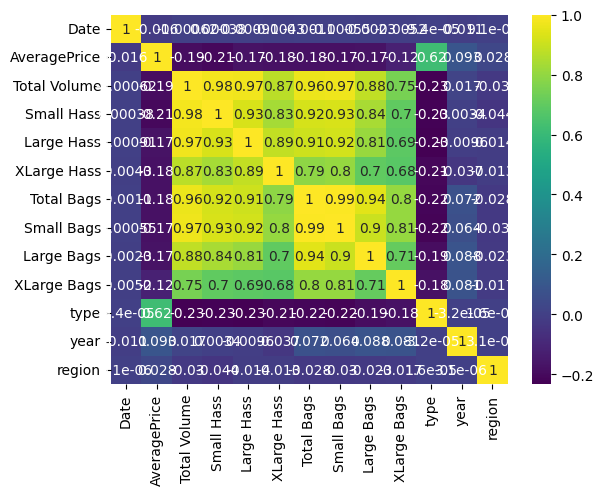

In [33]:
print('Матрица корреляций:')
sns.heatmap(df.corr(), cmap='viridis', annot=True)


Date
count    18249.000000
mean        83.995397
std         48.784682
min          0.000000
25%         42.000000
50%         84.000000
75%        126.000000
max        168.000000
Name: Date, dtype: float64


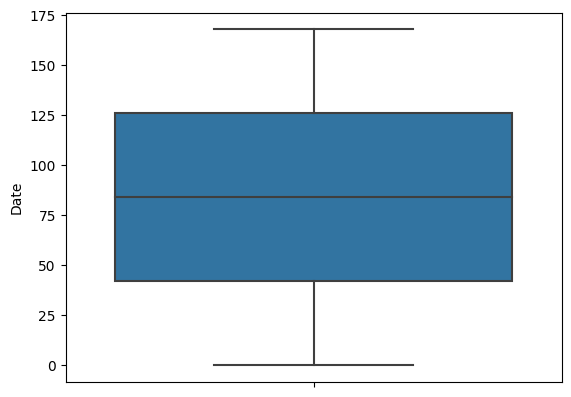

AveragePrice
count    18249.000000
mean         1.405978
std          0.402677
min          0.440000
25%          1.100000
50%          1.370000
75%          1.660000
max          3.250000
Name: AveragePrice, dtype: float64


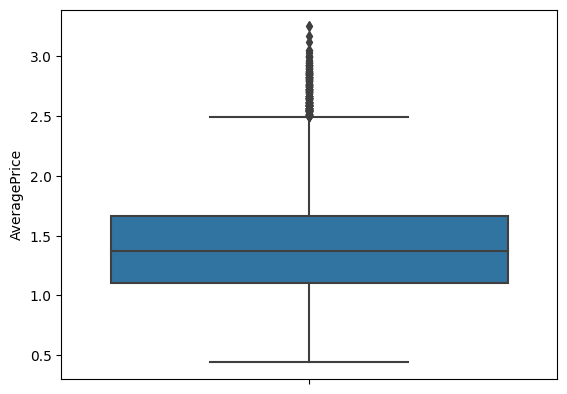

Total Volume
count    1.824900e+04
mean     8.506440e+05
std      3.453545e+06
min      8.456000e+01
25%      1.083858e+04
50%      1.073768e+05
75%      4.329623e+05
max      6.250565e+07
Name: Total Volume, dtype: float64


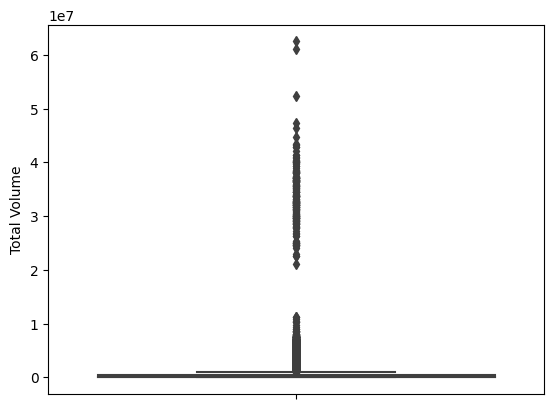

Small Hass
count    1.824900e+04
mean     2.930084e+05
std      1.264989e+06
min      0.000000e+00
25%      8.540700e+02
50%      8.645300e+03
75%      1.110202e+05
max      2.274362e+07
Name: Small Hass, dtype: float64


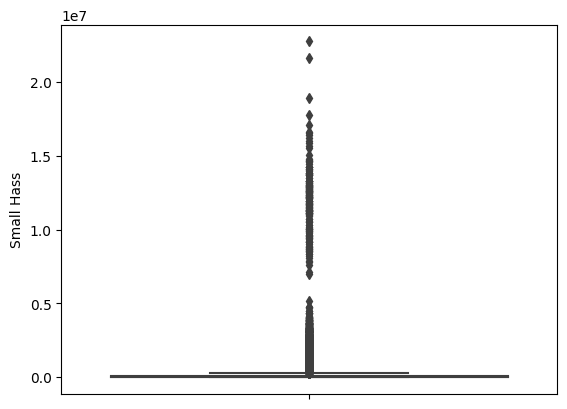

Large Hass
count    1.824900e+04
mean     2.951546e+05
std      1.204120e+06
min      0.000000e+00
25%      3.008780e+03
50%      2.906102e+04
75%      1.502069e+05
max      2.047057e+07
Name: Large Hass, dtype: float64


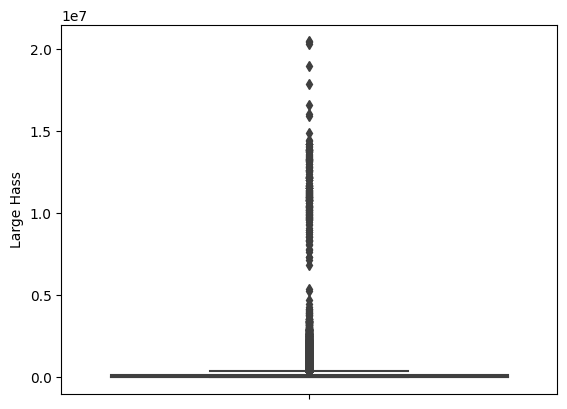

XLarge Hass
count    1.824900e+04
mean     2.283974e+04
std      1.074641e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.849900e+02
75%      6.243420e+03
max      2.546439e+06
Name: XLarge Hass, dtype: float64


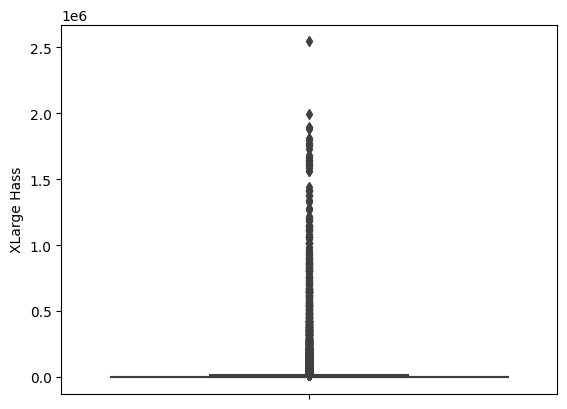

Total Bags
count    1.824900e+04
mean     2.396392e+05
std      9.862424e+05
min      0.000000e+00
25%      5.088640e+03
50%      3.974383e+04
75%      1.107834e+05
max      1.937313e+07
Name: Total Bags, dtype: float64


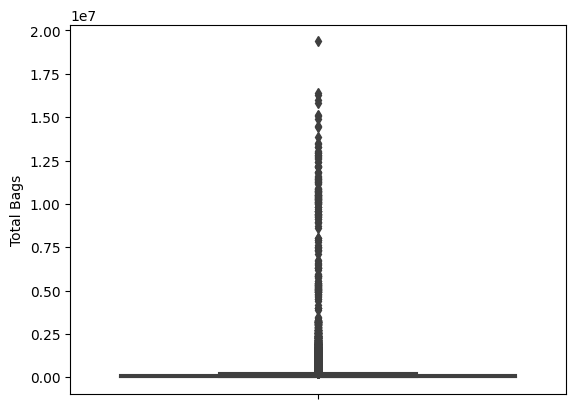

Small Bags
count    1.824900e+04
mean     1.821947e+05
std      7.461785e+05
min      0.000000e+00
25%      2.849420e+03
50%      2.636282e+04
75%      8.333767e+04
max      1.338459e+07
Name: Small Bags, dtype: float64


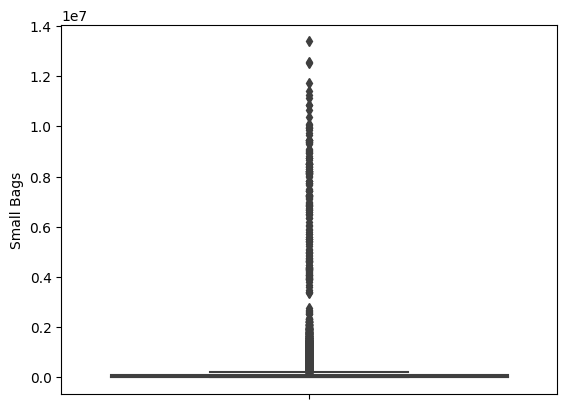

Large Bags
count    1.824900e+04
mean     5.433809e+04
std      2.439660e+05
min      0.000000e+00
25%      1.274700e+02
50%      2.647710e+03
75%      2.202925e+04
max      5.719097e+06
Name: Large Bags, dtype: float64


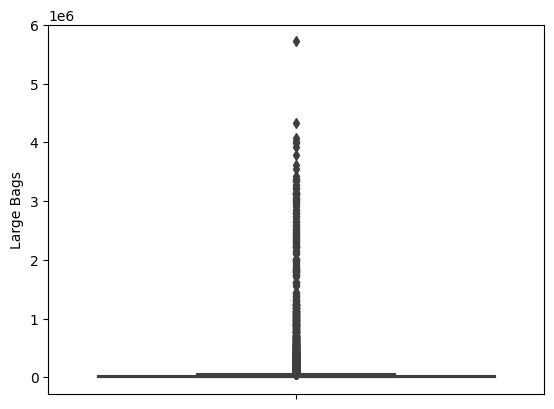

XLarge Bags
count     18249.000000
mean       3106.426507
std       17692.894652
min           0.000000
25%           0.000000
50%           0.000000
75%         132.500000
max      551693.650000
Name: XLarge Bags, dtype: float64


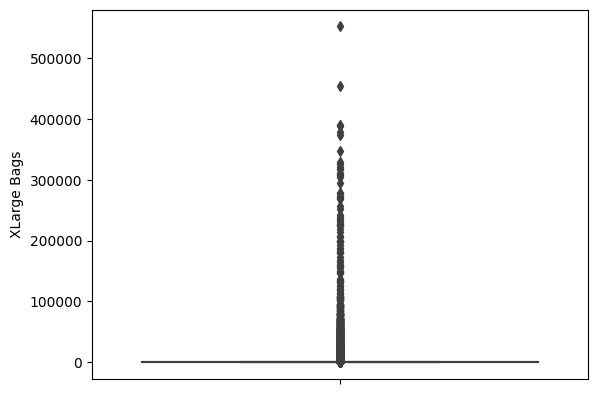

type
count    18249.000000
mean         0.499918
std          0.500014
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: type, dtype: float64


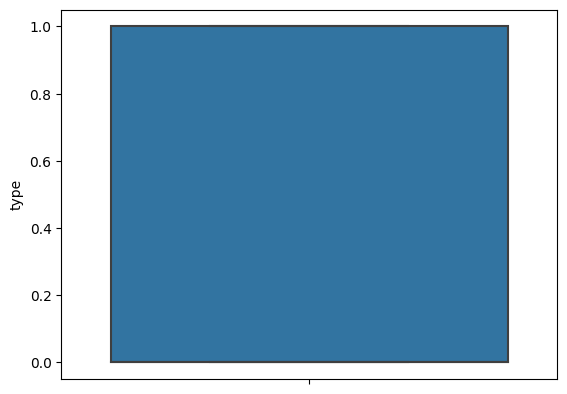

year
count    18249.000000
mean      2016.147899
std          0.939938
min       2015.000000
25%       2015.000000
50%       2016.000000
75%       2017.000000
max       2018.000000
Name: year, dtype: float64


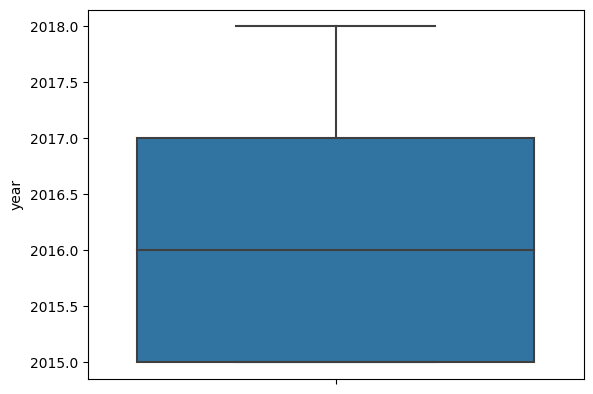

region
count    18249.000000
mean        26.500247
std         15.587480
min          0.000000
25%         13.000000
50%         27.000000
75%         40.000000
max         53.000000
Name: region, dtype: float64


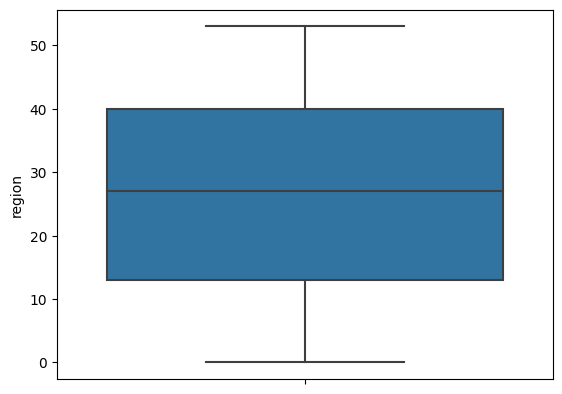

In [34]:
for c in df.columns:
    print(c)
    print(df[c].describe())
    sns.boxplot(y=c, data=df)
    plt.show()


Видно, что чистка данных не требуется.

In [35]:
X = df.dropna().reset_index().drop('AveragePrice', axis=1)
y = df.dropna().reset_index()['AveragePrice']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=838383)


## Задание 2

In [36]:
LR = LinearRegression()
LR.fit(X_train, y_train)
Y_LR = LR.predict(X_test)
print('Mean absolute error:', round(mean_absolute_error(y_test, Y_LR), 3))
print('Sqrt of mean squared error:', round(mean_squared_error(y_test, Y_LR)**(1/2), 3))
print('R2 score:', round(r2_score(y_test, Y_LR), 3))


Mean absolute error: 0.238
Sqrt of mean squared error: 0.308
R2 score: 0.412


In [37]:
coefs = abs(LR.coef_)
feature_importance = pd.DataFrame(
    columns=['Название признака', 'Важность признака'])
feature_importance['Название признака'] = X.keys()
feature_importance['Важность признака'] = coefs/sum(coefs)
feature_importance = feature_importance.sort_values(
    by='Важность признака', ascending=False)
print('Наиболее информативные признаки')
feature_importance


Наиболее информативные признаки


,Название признака,Важность признака
10,type,8.609886e-01
11,year,7.215500e-02
6,Total Bags,1.639162e-02
8,Large Bags,1.630675e-02
7,Small Bags,1.630643e-02
9,XLarge Bags,1.630374e-02
12,region,9.518705e-04
1,Date,2.557768e-04
4,Large Hass,8.533333e-05
2,Total Volume,8.515098e-05


Наиболее информативный - тип

Text(0, 0.5, 'Predict AveragePrice')

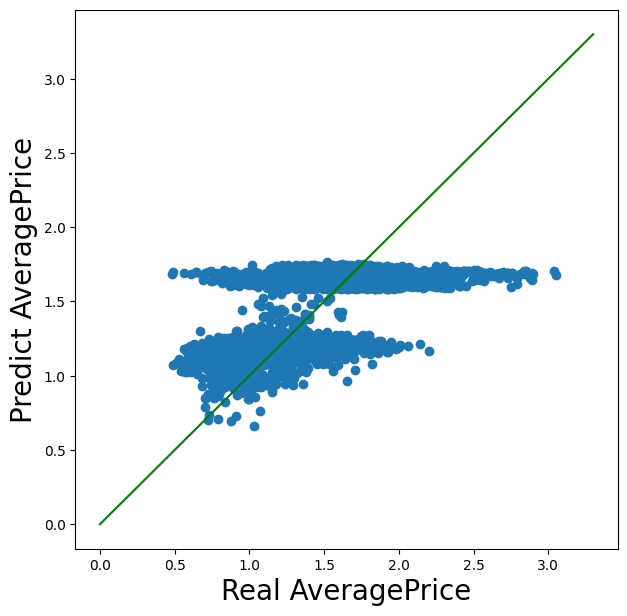

In [38]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, Y_LR)
plt.plot([0, 3.3], [0, 3.3], color='g')
plt.xlabel('Real AveragePrice', fontsize=20)
plt.ylabel('Predict AveragePrice', fontsize=20)


## Задание 3

In [39]:
gb = XGBRegressor(objective='reg:squarederror')
gb.fit(X_train, y_train)
Y_GB = gb.predict(X_test)
print('Mean absolute error:', round(mean_absolute_error(y_test, Y_GB), 3))
print('Sqrt of mean squared error:', round(mean_squared_error(y_test, Y_GB)**(1/2), 3))
print('R2 score:', round(r2_score(y_test, Y_GB), 3))


Mean absolute error: 0.107
Sqrt of mean squared error: 0.148
R2 score: 0.865


Видно, что R2 бустингом получился в 2 раза больше, чем лин. регрессией.

In [40]:
feature_importance = pd.DataFrame(
    columns=['Название признака', 'Важность признака'])
feature_importance['Название признака'] = X.keys()
feature_importance['Важность признака'] = gb.feature_importances_
feature_importance = feature_importance.sort_values(
    by='Важность признака', ascending=False)
print('Наиболее информативные признаки')
feature_importance


Наиболее информативные признаки


,Название признака,Важность признака
10,type,0.909900
11,year,0.019722
8,Large Bags,0.011249
12,region,0.010015
3,Small Hass,0.008724
6,Total Bags,0.007186
4,Large Hass,0.006315
9,XLarge Bags,0.006216
7,Small Bags,0.005592
1,Date,0.005550


Еаиболее информативный также - тип

Text(0, 0.5, 'Predict AveragePrice')

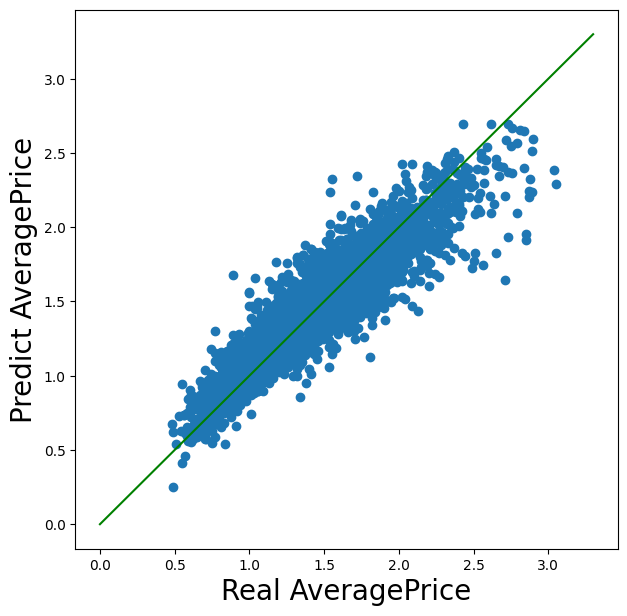

In [41]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, Y_GB)
plt.plot([0, 3.3], [0, 3.3], color='g')
plt.xlabel('Real AveragePrice', fontsize=20)
plt.ylabel('Predict AveragePrice', fontsize=20)


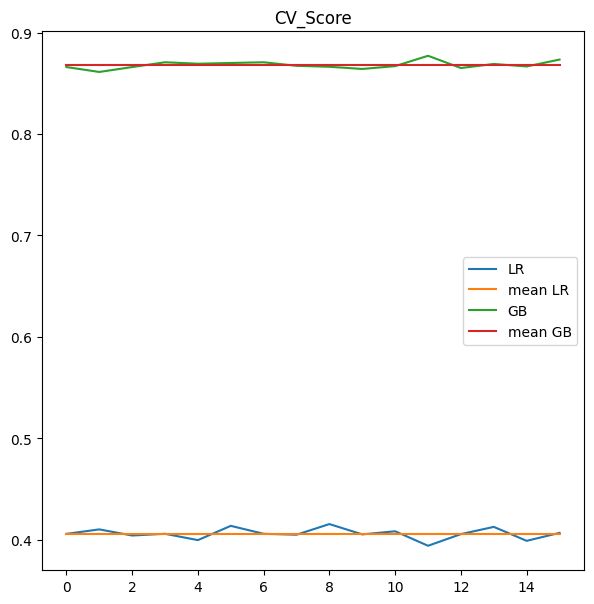

In [42]:
n = 4
cv_model_lr = cross_validate(LR, X, y, cv=RepeatedKFold(
    n_splits=n, n_repeats=n), return_estimator=False, n_jobs=1)
cv_model_gb = cross_validate(gb, X, y, cv=RepeatedKFold(
    n_splits=n, n_repeats=n), return_estimator=False, n_jobs=1)
x_i = range(0, n*n)
y_1 = cv_model_lr['test_score']
y_2 = cv_model_gb['test_score']
plt.subplots(figsize=(7, 7))
plt.title('CV_Score')
plt.plot(x_i, y_1, label='LR')
plt.plot([0, n*n - 1], [y_1.mean()]*2, label='mean LR')
plt.plot(x_i, y_2, label='GB')
plt.plot([0, n*n - 1], [y_2.mean()]*2, label='mean GB')
plt.legend()


## Задание 4

Помним, что наиболее информативная - тип

C:\Users\111\AppData\Local\Temp\ipykernel_10200\2085866645.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter((X[start:end][X['type'] == 0]).index,
C:\Users\111\AppData\Local\Temp\ipykernel_10200\2085866645.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter((X[start:end][X['type'] == 1]).index,


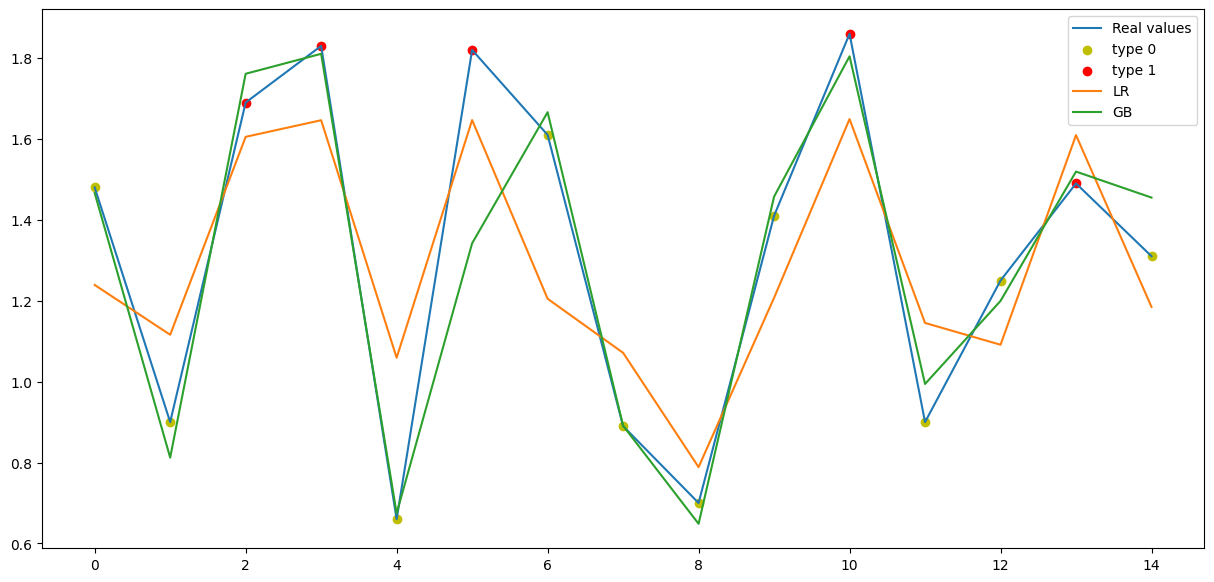

In [43]:
start = 0
end = 15
plt.subplots(figsize=(end, end//2))
plt.plot(X.index[start:end], y[start:end], label='Real values')
plt.scatter((X[start:end][X['type'] == 0]).index,
            y[start:end][X['type'] == 0], label='type 0', c='y')
plt.scatter((X[start:end][X['type'] == 1]).index,
            y[start:end][X['type'] == 1], label='type 1', c='r')
plt.plot(X.index[start:end], LR.predict(X)[start:end], label='LR')
plt.plot(X.index[start:end], gb.predict(X)[start:end], label='GB')
plt.legend()
